<a href="https://colab.research.google.com/github/Hritik-Ubale/LetsGrowMore_VirtualInternshipProgram/blob/main/Task3_MusicRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

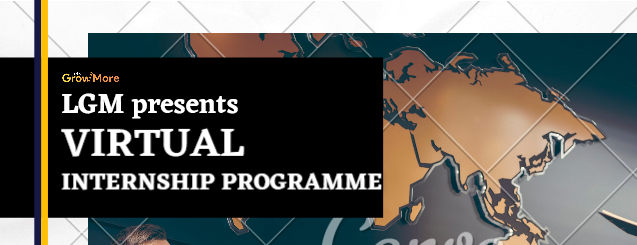

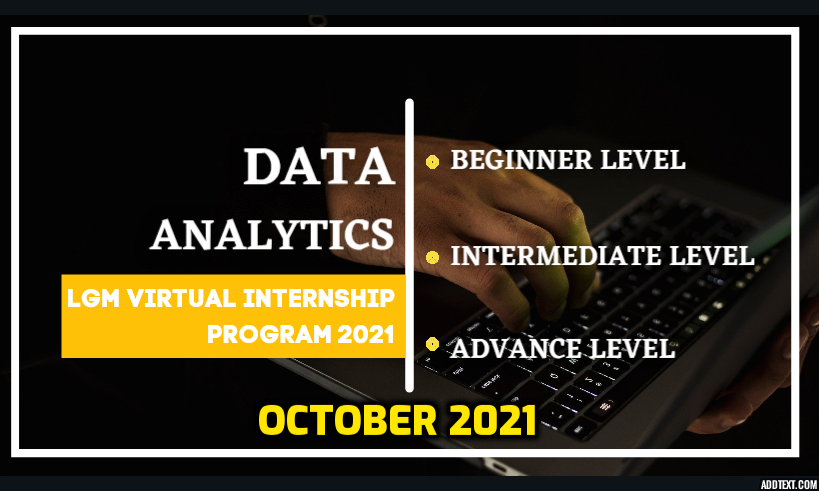

# **INTERN / AUTHOR : HRITIK JITENDRA UBALE**

# **TASK 3**

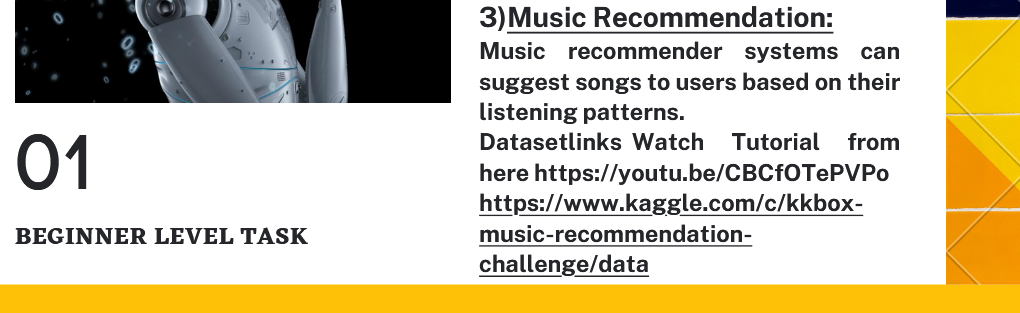

# **The goal here is to Predict and Recommend Songs to the user based on his previous streams.**

![picture](https://miro.medium.com/max/1066/1*MnedC576EFf7dfeKmPBkiQ.png)

# **Recommender code.**

In [ ]:
import numpy as np
import pandas

#Class for Popularity based Recommender System model
class popularity_recommender():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

#Class for Item similarity based Recommender System model
class item_similarity_recommender():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pandas.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

# **Importing the necessary libraries.**

In [ ]:
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import main as Recommenders

# **Importing the dataset.**

In [ ]:
song_metadata_file = pd.read_csv('SongData.csv')

In [ ]:
song_metadata_file.shape

(1000, 5)

In [ ]:
song_metadata_file.head

<bound method NDFrame.head of                 song_id                   title  ...       artist_name  year
0    SOQMMHC12AB0180CB8            Silent Night  ...  Faster Pussy cat  2003
1    SOVFVAK12A8C1350D9             Tanssi vaan  ...  Karkkiautomaatti  1995
2    SOGTUKN12AB017F4F1       No One Could Ever  ...    Hudson Mohawke  2006
3    SOBNYVR12A8C13558C           Si Vos Querés  ...       Yerba Brava  2003
4    SOHSBXH12A8C13B0DF        Tangle Of Aspens  ...        Der Mystic     0
..                  ...                     ...  ...               ...   ...
995  SOLJZWG12A67AE2555  Blue Days (Dias Azuis)  ...      Lee Ritenour  2006
996  SOELTHK12A8C13E0D1      Walking In Memphis  ...    Master Blaster  2007
997  SOGMELB12AB018F6A6                Suddenly  ...    BT feat. Erire  2010
998  SORVSPU12A8C133397           Along the Way  ...         Devotchka  2008
999  SOPQWHM12AB018ACF1         Shattered Cross  ...     Darrell Scott  2006

[1000 rows x 5 columns]>

**Importing the userid-songid-listen-count triplets.**

In [ ]:
triplets_file = 'Thousand.txt'

**Dataframe for triplet file.**

In [ ]:
song_df1 = pd.read_table(triplets_file, header = None)
song_df1.columns = ['user_id','song_id','listen_count'] 

**Dataframe for song data file.**

In [ ]:
song_df2 = song_metadata_file

# **Merge the above two dataframes to get a single input data frame for recommender system.**

In [ ]:
song_df = pd.merge(song_df1,song_df2.drop_duplicates(['song_id']),on="song_id",how='left')
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,NaN,NaN,NaN,NaN
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,NaN,NaN,NaN,NaN
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,NaN,NaN,NaN,NaN
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,NaN,NaN,NaN,NaN
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,NaN,NaN,NaN,NaN


**Find length of data set.**

In [ ]:
print("total numberof training data:",len(song_df))

total numberof training data: 1001


## **Merge song title and song artist into one column for our analysis.**

In [ ]:
song_df['song'] = song_df['title'].map(str)+"-"+song_df['artist_name']

**Count the number of unique users.**

In [ ]:
users = song_df['user_id'].unique()
len(users)

20

**Count the number of unique songs.**

In [ ]:
songs = song_df['song'].unique()
len(songs)

2

# **Split the whole data into training and testing data.** we have kept 30% data for testing rest for training.

In [ ]:
train_data , test_data = train_test_split(song_df,test_size = 0.30, random_state = 0)

# **For a personalized song recommender , we will use item similarity filter based recommender.**

In [ ]:
is_model = Recommenders.item_similarity_recommender()
is_model.create(train_data,'user_id','song')

In [ ]:
song = 'Hudson Mohawke'
is_model.get_similar_items(['Hudson Mohawke'])

no. of unique songs in the training set: 2
Non zero values in cooccurence_matrix :0


,user_id,song,score,rank
0,,Anyone Else But You-Michael Cera & Ellen Page,0.0,1
1,,NaN,0.0,2


# **Hence, we have made our personalized music recommender.** 
But as I have only considered the dataset for 1000 songs the results are not that exciting. You can opt for heavier datasets for best results.

![picture](https://image.shutterstock.com/image-vector/thank-you-hand-drawn-lettering-260nw-780491263.jpg)